In [1]:
# Import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from datasets import load_dataset
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm.auto import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
import os
import random
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Define the number of epochs
num_epochs = 10

# Define the batch size
batch_size = 16

# Define the input shape
input_shape = (224, 224)

In [3]:
class AffectNetHqDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
def heatmap_generator(image):
    face_locations = face_recognition.face_locations(image)

    # Load the pre-trained facial landmark model
    face_landmarks_list = face_recognition.face_landmarks(image, face_locations)

    h,w = image.shape[:2]
    lm = np.zeros([h,w])

    # Draw facial landmarks on the image
    for face_landmarks in face_landmarks_list:
        for landmark_type, landmarks in face_landmarks.items():
            for (x, y) in landmarks:
                if x < h and y < w :
                    lm[y,x] = 1

    heatmap = cv2.GaussianBlur(lm, [59,59], 3)         

    return heatmap

In [5]:
import torch
import torch.nn as nn

class PrivilegedAttributionLoss(nn.Module):
    def __init__(self):
        super(PrivilegedAttributionLoss, self).__init__()

    def forward(self, attribution_maps, prior_maps):
        # Add a small value to standard deviation to avoid division by zero
        epsilon = 1e-8

        # Calculate mean and standard deviation for each sample in the batch
        mean_al = torch.mean(attribution_maps, dim=[1, 2, 3], keepdim=True)  # Assuming BCHW format
        std_al = torch.std(attribution_maps, dim=[1, 2, 3], keepdim=True) + epsilon

        # Calculate the PAL loss
        # Ensure that the broadcasting in the subtraction and division is correct
        pal_loss = -torch.sum((attribution_maps - mean_al) / std_al * prior_maps, dim=[1, 2, 3])

        # Return the mean loss over the batch
        return torch.mean(pal_loss)


In [6]:
# Load the full dataset
full_dataset = load_dataset("Piro17/affectnethq", split='train')

# Split the dataset into train and test subsets
train_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation((-10, 10)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset and dataloader using the subsets
train_dataset = AffectNetHqDataset(Subset(full_dataset, train_subset.indices), transform=train_transform)
test_dataset = AffectNetHqDataset(Subset(full_dataset, test_subset.indices), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [12]:
import torchvision
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim

# Charger le modèle pré-entraîné ResNet50
base_model = torchvision.models.resnet50(pretrained=True)

# Supprimer la dernière couche entièrement connectée (fc)
base_model = nn.Sequential(*list(base_model.children())[:-1])

# Ajouter une nouvelle couche adaptée à 7 classes
num_classes = 7
classifier_layer = nn.Linear(2048, num_classes)  # ResNet50 utilise 2048 features avant la couche fc
model = nn.Sequential(base_model, nn.Flatten(), classifier_layer)

# Afficher la structure du modèle
summary(model, (3, 224, 224))  # Assurez-vous d'ajuster les dimensions en fonction de vos données

# Identifier la dernière couche de convolution
# Pour ResNet50, la dernière couche de convolution est la dernière couche de la partie 'base_model'
# Identifier la dernière couche de convolution dans ResNet50
# Notez que dans ResNet50, la dernière couche de convolution se trouve dans la dernière "Bottleneck"
last_conv_layer = list(base_model.children())[-3][2].conv3
print("last conv layer =", last_conv_layer)

# Définir l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=4e-5)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

  0%|          | 0/348 [00:00<?, ?it/s]

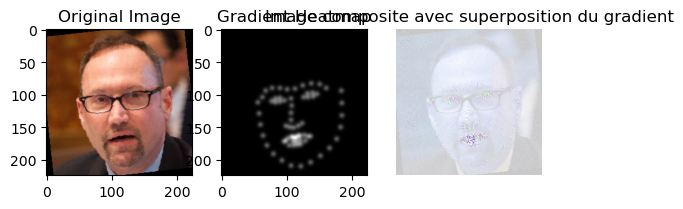

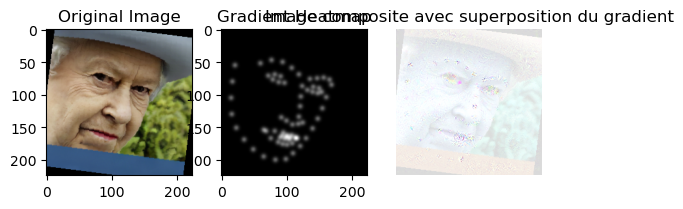

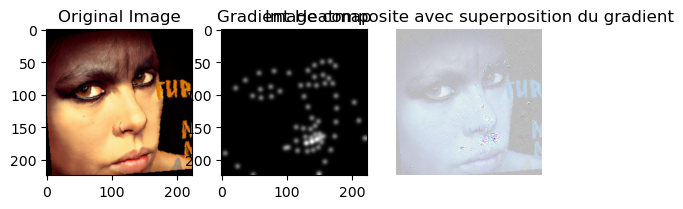

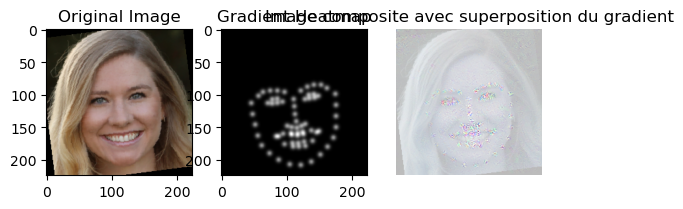

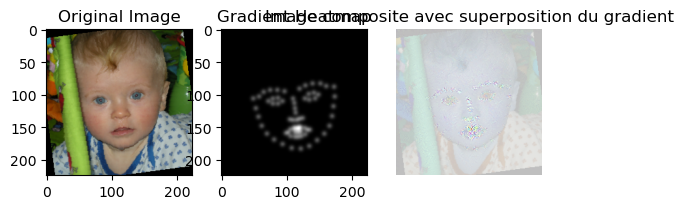

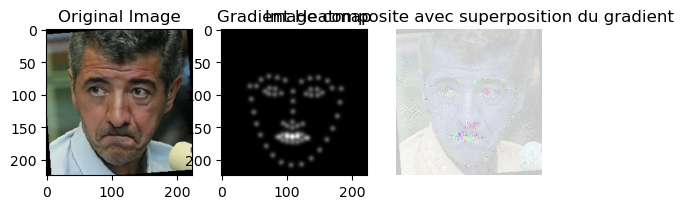

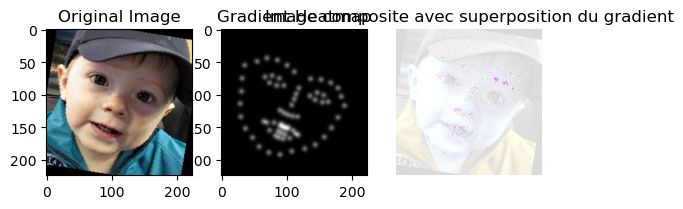

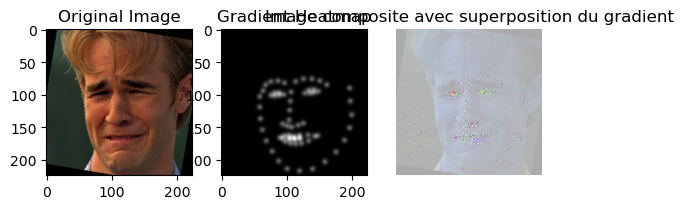

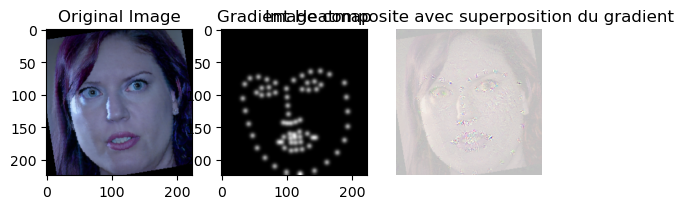

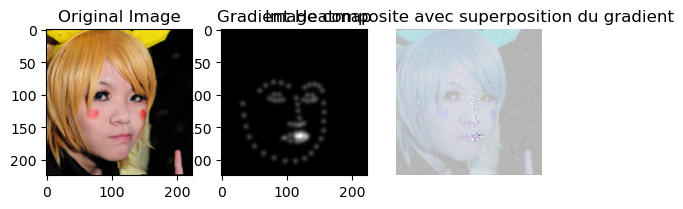

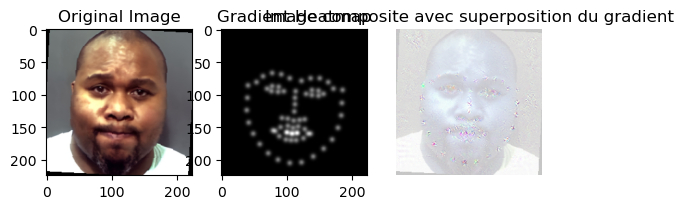

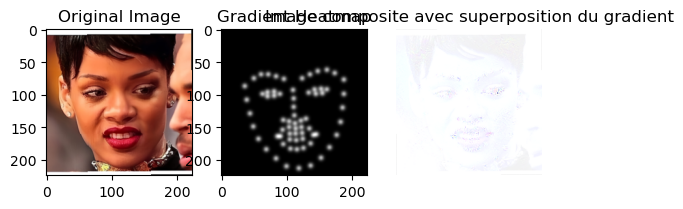

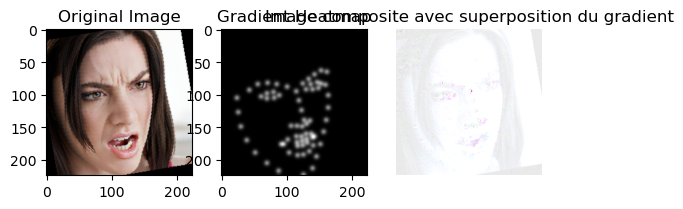

/var/folders/r0/622tvs3d2770yx_xp44vfl5h0000gn/T/ipykernel_23007/824895049.py:82: RuntimeWarning: invalid value encountered in cast
  gradient_image_uint8 = np.uint8(255 * gradient_image)  # Convertir en entier 8 bits non signé


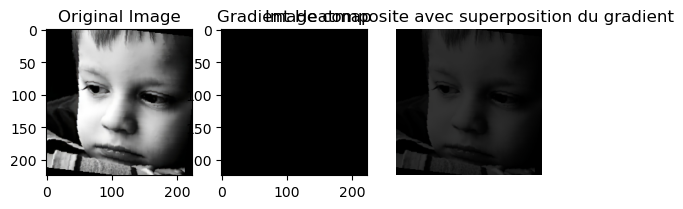

In [17]:
# Attacher un hook pour enregistrer le gradient
from matplotlib.colors import LinearSegmentedColormap

num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()
loss_values = [] 
accuracy_values = []  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_pal_loss = 0.0
    running_corrects = 0.0
    total_samples = 0.0
    for images, labels in tqdm(train_loader):

        # Convert the PyTorch tensor to a NumPy array
        cv2_image = images[0].permute(1, 2, 0).cpu().detach().numpy()

        # Ensure the image is in the correct type for OpenCV
        if cv2_image.dtype != np.uint8:
            cv2_image = (cv2_image * 255).astype(np.uint8)

        # Convert from BGR to RGB for face recognition
        cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)

        heatmap = heatmap_generator(cv2_image)
        heatmapa = torch.from_numpy(heatmap).float()

        heatmapa = heatmapa / torch.max(heatmapa)  # Normalize the heatmap
        if heatmapa == None :
            pass
        else : 
            # Ensure that images require gradients
            images.requires_grad_()

            # Forward pass
            outputs = model(images)
            labels = labels.long()

            # Calcul de la classification loss
            classification_loss = criterion(outputs, labels)

            # Backward pass for gradients with respect to the input images
            classification_loss.backward(retain_graph=True)  
            gradients = images.grad ## Recuperate the gradients who saved in the hook

            # Compute the attribution maps as the element-wise product of the gradients and the input images
            attribution_maps = gradients * images

            # Compute the PAL loss using the attribution maps and the prior maps
            pal_loss_fn = PrivilegedAttributionLoss()
            pal_loss = pal_loss_fn(attribution_maps, heatmapa)

            # Calcul de la PAL loss et de la classification loss
            total_loss = classification_loss + pal_loss

            # Backpropagation et optimisation
            optimizer.zero_grad()  # Clear gradients before the backward pass
            total_loss.backward()
            optimizer.step()

            # Mise à jour des running loss et PAL loss
            running_loss += classification_loss.item()
            running_pal_loss += pal_loss.item()         

            if epoch == 0 :
                # Visualize the original image
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB))  
                plt.title('Original Image')

                # Visualize the heatmap
                plt.subplot(1, 3, 2)
                plt.imshow(heatmap, cmap='gray')
                plt.title('Gradient Heatmap')

                # Préparation de l'image du gradient
                grad_times_input_np = gradients[0].cpu().detach().numpy()  # Récupérer les gradients pour la première image du lot
                grad_times_input_rescaled = (grad_times_input_np - grad_times_input_np.min()) / (grad_times_input_np.max() - grad_times_input_np.min())  # Rescaler les gradients à [0, 1]
                gradient_image = grad_times_input_rescaled.transpose(1, 2, 0)  # Transposer les dimensions si nécessaire
                gradient_image_uint8 = np.uint8(255 * gradient_image)  # Convertir en entier 8 bits non signé

                # Superposer l'image du gradient sur l'image d'origine
                composite_image = cv2.addWeighted(cv2_image, 0.2, gradient_image_uint8, 1.5, 0)

                # Afficher l'image composite
                plt.subplot(1, 3, 3)
                plt.imshow(composite_image)
                plt.title('Image composite avec superposition du gradient')
                plt.axis("off")
                plt.show()

            # Calcul de la classification loss et de la PAL loss
            total_loss = classification_loss + pal_loss

            # Mise à jour des running loss et PAL loss
            running_loss += classification_loss.item()
            running_pal_loss += pal_loss.item()

     